In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob
from PIL import ImageFile
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
from tensorflow.keras.applications import VGG16
import tensorflow.keras.models as Models
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras import layers
#from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import Callback

In [48]:
INPUT_SHAPE = (150,150,3)
BATCH_SIZE = 100
test_path= r'C:\Users\User\Group_28-AI-Insects\test'
train_path= r'C:\Users\User\Group_28-AI-Insects\train'
valid_path = r'C:\Users\User\Group_28-AI-Insects\val'
samp_path = r'C:\Users\User\Group_28-AI-Insects\extra_test_img'

In [36]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [37]:
filepaths_train = list(glob.glob(train_path+'/**/*.jpg'))
filepaths_test = list(glob.glob(test_path+'/**/*.jpg'))

In [38]:
train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)

In [39]:
train_df

,Filepath,Label
0,C:\Users\User\Group_28-AI-Insects\train\Locust...,Locustoidea
1,C:\Users\User\Group_28-AI-Insects\train\bliste...,blister beetle
2,C:\Users\User\Group_28-AI-Insects\train\Mirida...,Miridae
3,C:\Users\User\Group_28-AI-Insects\train\Cicade...,Cicadellidae
4,C:\Users\User\Group_28-AI-Insects\train\cabbag...,cabbage army worm
...,...,...
45090,C:\Users\User\Group_28-AI-Insects\train\Triale...,Trialeurodes vaporariorum
45091,C:\Users\User\Group_28-AI-Insects\train\Beet s...,Beet spot flies
45092,C:\Users\User\Group_28-AI-Insects\train\Cicade...,Cicadellidae
45093,C:\Users\User\Group_28-AI-Insects\train\green ...,green bug


In [40]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of test pictures: {test_df.shape[0]}')

Number of training pictures: 45095
Number of test pictures: 22619


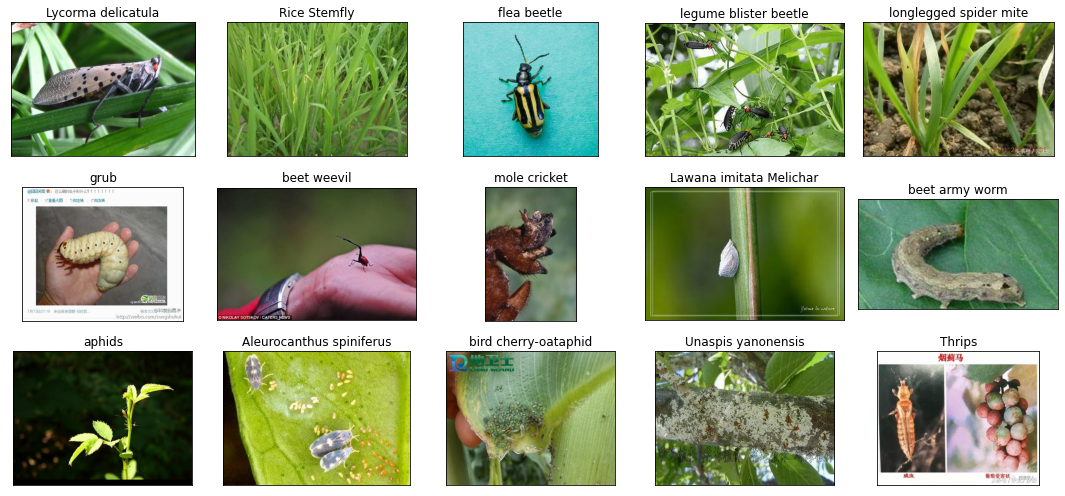

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

In [41]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [42]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split = 0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [54]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 36076 validated image filenames belonging to 102 classes.
Found 9019 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


In [46]:
labels = (test_images.class_indices)

In [27]:
from tensorflow.keras.applications import VGG16

pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

In [28]:
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(102, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 



last layer of vgg : output shape:  (None, 4, 4, 512)


In [29]:
checkpoint_path = "models_t/cp.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 verbose=1)

In [30]:
model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [65]:
history = model_vgg.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[cp_callback]
)

Epoch 1/20
1128/1128 [==============================] - 2536s 2s/step - loss: 6.0557 - acc: 0.2488 - val_loss: 3.1838 - val_acc: 0.3450

Epoch 00001: val_loss improved from inf to 3.18383, saving model to models_t\cp.h5
Epoch 2/20
1128/1128 [==============================] - 2585s 2s/step - loss: 2.3961 - acc: 0.4949 - val_loss: 3.2274 - val_acc: 0.4206

Epoch 00002: val_loss did not improve from 3.18383
Epoch 3/20
1128/1128 [==============================] - 2532s 2s/step - loss: 1.4933 - acc: 0.6637 - val_loss: 3.4101 - val_acc: 0.4540

Epoch 00003: val_loss did not improve from 3.18383
Epoch 4/20
1128/1128 [==============================] - 2461s 2s/step - loss: 0.9186 - acc: 0.7782 - val_loss: 3.8088 - val_acc: 0.4680

Epoch 00004: val_loss did not improve from 3.18383
Epoch 5/20
1128/1128 [==============================] - 2528s 2s/step - loss: 0.5861 - acc: 0.8553 - val_loss: 4.0993 - val_acc: 0.4769

Epoch 00005: val_loss did not improve from 3.18383
Epoch 6/20
1128/1128 [======

In [72]:
pred = model_vgg.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['wireworm', 'aphids', 'aphids', 'Lycorma delicatula', 'Cicadellidae']


In [73]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                 precision    recall  f1-score   support

                  Adristyrannus       0.59      0.32      0.41        94
       Aleurocanthus spiniferus       0.83      0.79      0.81       208
                    Ampelophaga       0.68      0.58      0.62       230
    Aphis citricola Vander Goot       0.52      0.46      0.49       106
               Apolygus lucorum       0.30      0.22      0.25       115
           Bactrocera tsuneonis       0.41      0.24      0.30        51
                Beet spot flies       0.60      0.44      0.51        90
   Brevipoalpus lewisi McGregor       0.71      0.50      0.59        24
             Ceroplastes rubens       0.63      0.54      0.58        78
           Chlumetia transversa       0.54      0.41      0.47        92
          Chrysomphalus aonidum       0.43      0.47      0.45        68
              Cicadella viridis       0.58      0.64      0.61       384
                   Cicadellidae       0.63      0.

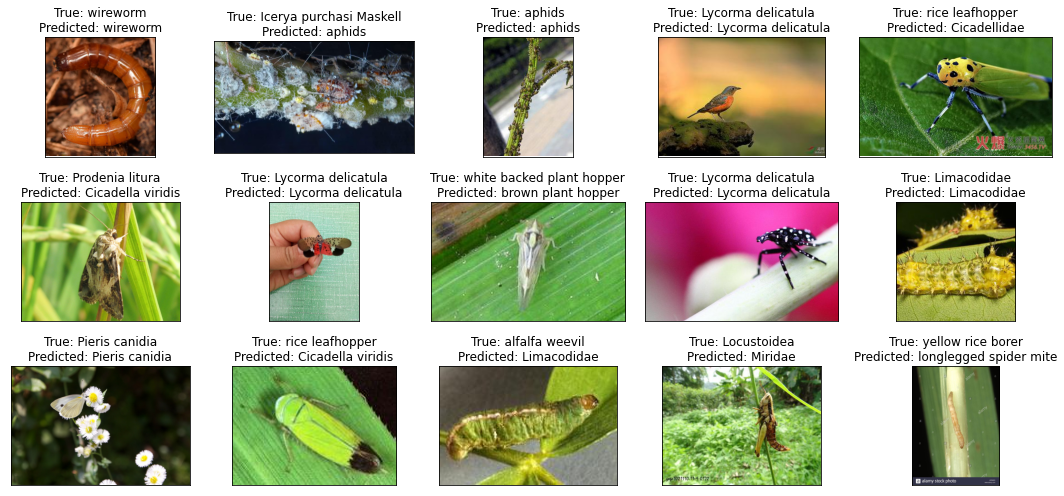

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [75]:
results = model_vgg.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 8.18968
Test Accuracy: 53.38%


In [77]:
model.save('myModel_VGG16.h5')

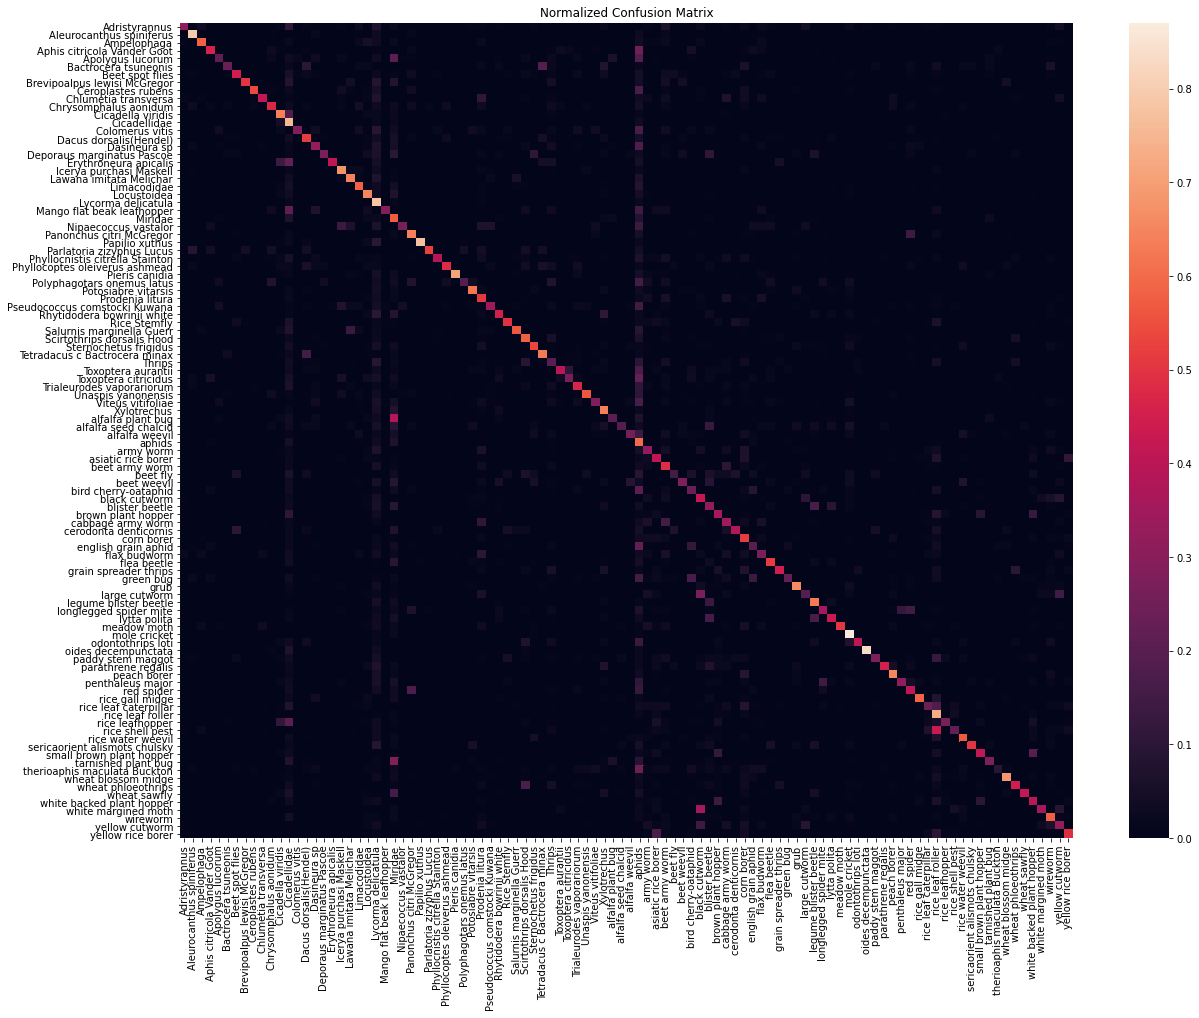

In [76]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [114]:
from imageai.Classification.Custom import CustomImageClassification
import os

execution_path = os.getcwd()

prediction = CustomImageClassification()
prediction.setModelTypeAsMobileNetV2()
prediction.setModelPath(os.path.join(execution_path,"myModel.h5"))
prediction.setJsonPath(os.path.join(execution_path, "model_class.json"))
prediction.loadModel(num_objects=102)

predictions, probabilities = prediction.classifyImage(os.path.join(execution_path, "Trialeurodes vaporariorum.jpg"), result_count=5)

for eachPrediction, eachProbability in zip(predictions, probabilities):
    print(eachPrediction , " : " , eachProbability)

ValueError: You are trying to load a weight file containing 107 layers into a model with 105 layers.

In [2]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [3]:
plot_accuracy_loss(history)

NameError: name 'history' is not defined

In [30]:
v16 = Models.load_model('myModel_VGG16.h5', compile = False) 

In [14]:
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
    
        size = (150,150)    
        image_data = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(150, 150),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img_resize[np.newaxis,...]
    
        prediction = v16.predict(img_reshape)
        
        return prediction

In [27]:
im1 = Image.open(r"C:\Users\User\Group_28-AI-Insects\Thrips.jpg")

In [33]:
def teachable_machine_classification(img, weights_file):
    v16 = Models.load_model('myModel_VGG16.h5', compile = False)
    
    data = np.ndarray(shape = (1, 150, 150, 3), dtype = np.float32)
    image = img
    image = ImageOps.fit(image, (150,150), Image.ANTIALIAS)
    
    image_array = np.asarray(image)
    
    normalized_image_array = (image_array.astype(np.float32)/255)
    
    data[0] = normalized_image_array
    
    prediction_percentage = v16.predict(data)
    prediction = prediction_percentage.round()
    
    return prediction, prediction_percentage

In [51]:
classPath = 'C:\\Users\\User\\Group_28-AI-Insects\\classes.txt'
classes=[]

In [52]:
with open(classPath, 'r') as File:
    infoFile = File.readlines() 
    for line in infoFile: 
        words = line.strip() 
        classes.append(words[3:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


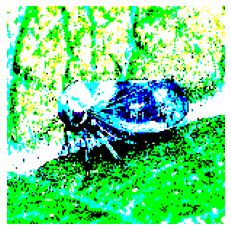

In [60]:
x, y = next(iter(test_images))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = v16.predict(np.expand_dims(image, axis = 0))
#predicted_index = np.argmax(prediction_scores)
#print("True label: " + classes[true_index])
#print("Predicted label: " + classes[predicted_index])

In [61]:
prediction_scores

array([[[[6.05523765e-01, 1.31538513e-06, 1.64603819e-07, ...,
          1.24449045e-07, 1.17836612e-08, 7.17111761e-05],
         [3.90089571e-01, 6.71108064e-05, 8.07651972e-08, ...,
          1.74577323e-07, 9.07882196e-08, 1.68478102e-04],
         [4.87773299e-01, 5.33237908e-05, 2.26151988e-05, ...,
          1.51717995e-06, 3.18857275e-07, 1.78318494e-03],
         [6.46088004e-01, 1.41396285e-05, 6.71155940e-05, ...,
          7.61650881e-07, 2.13621362e-07, 3.30805866e-04]],

        [[2.46480219e-02, 1.10658721e-06, 4.16856665e-07, ...,
          3.50618623e-09, 8.65134496e-07, 2.16759399e-05],
         [2.81309889e-11, 1.45879522e-12, 4.73633885e-21, ...,
          1.77402866e-24, 2.85511264e-21, 1.65735842e-10],
         [3.60137142e-10, 8.00736217e-19, 2.41044608e-18, ...,
          7.65875518e-23, 1.10930906e-20, 6.20646219e-08],
         [2.02743904e-05, 1.46375537e-10, 1.03281446e-12, ...,
          2.38737719e-12, 9.21524625e-16, 1.63222253e-08]],

        [[1.13463194

In [34]:
teachable_machine_classification(im1, v16)

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32),
 array([[[[0.02120142, 0.00609372, 0.00809998, ..., 0.00463989,
           0.00852349, 0.01125518],
          [0.02198507, 0.00544918, 0.00807072, ..., 0.00486601,
           0.0086265 , 0.01139153],
          [0.02090465, 0.00517491, 0.00843951, ..., 0.00506362,
           0.00769163, 0.01200963],
          [0.018

In [16]:
prediction = v16.predict("Trialeurodes vaporariorum.jpg")

IndexError: list index out of range

In [6]:
v16.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [33]:
v16.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [35]:
loss, acc = v16.evaluate(test_images, labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.